# PROJECT LUNG DISEASES

## REQUIREMENT

In [2]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Bidirectional, LSTM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

## DATA PREP

In [3]:
# flow_from_directory
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

### Datagenerator

In [4]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,            
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16,
    
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 8
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [5]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in resnet_model.layers:
    layer.trainable = True

94781440/94765736 [==============================] - 3s 0us/step


### Project Model

In [6]:
#Membuat model
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(TimeDistributed(Flatten()))
model_resnet.add(Bidirectional(LSTM(64, return_sequences=True)))
model_resnet.add(Bidirectional(LSTM(16, return_sequences=True)))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(64, activation='relu'))
model_resnet.add(Dense(16, activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_resnet.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 14336)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 128)            7373312   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 7, 32)             18560     
_________________________________________________________________
dropout (Dropout)            (None, 7, 32)             0         
_________________________________________________________________
dense (Dense)                (None, 7, 64)             2112      
_________________________________________________________________
dense_1 (Dense)              (None, 7, 16)             1

In [7]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True       
                
callback = CustomCallback()
# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator#,
    #callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 159s 368ms/step - loss: 1.4980 - acc: 0.3872 - val_loss: 1.6494 - val_acc: 0.1446
Epoch 2/30
380/380 [==============================] - 90s 238ms/step - loss: 1.1731 - acc: 0.6041 - val_loss: 1.5312 - val_acc: 0.2790
Epoch 3/30
380/380 [==============================] - 91s 239ms/step - loss: 0.8917 - acc: 0.7347 - val_loss: 0.8066 - val_acc: 0.7617
Epoch 4/30
380/380 [==============================] - 91s 238ms/step - loss: 0.6884 - acc: 0.8104 - val_loss: 0.5634 - val_acc: 0.8473
Epoch 5/30
380/380 [==============================] - 90s 235ms/step - loss: 0.5406 - acc: 0.8622 - val_loss: 0.6318 - val_acc: 0.7566
Epoch 6/30
380/380 [==============================] - 90s 237ms/step - loss: 0.4528 - acc: 0.8811 - val_loss: 0.4644 - val_acc: 0.8401
Epoch 7/30
380/380 [==============================] - 91s 239ms/step - loss: 0.3820 - acc: 0.9020 - val_loss: 0.5277 - val_acc: 0.7862
Epoch 8/30
380/380 [==============================] - 

model_resnet.save("resnet_model.h5")
with open('history_resnet.txt', mode='w') as file:
    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
    file.close()

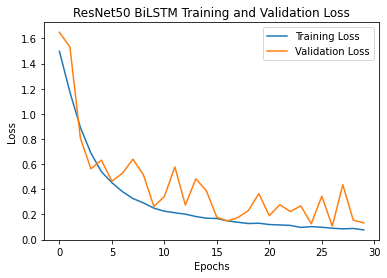

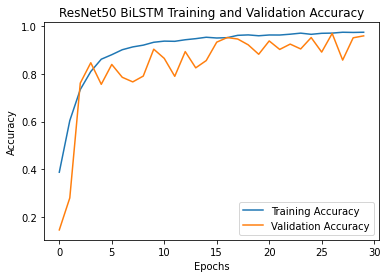

In [8]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 5s 41ms/step - loss: 0.1330 - acc: 0.9603
Loss: 0.13303188979625702
Accuracy: 0.9602851271629333


In [10]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nResNet50 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 83s 213ms/step

ResNet50 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.20392   0.20492   0.20442      1220
            covid19    0.18721   0.19549   0.19126      1243
             normal    0.21120   0.20162   0.20630      1235
       tuberculosis    0.17793   0.17778   0.17785      1170
    viral_pneumonia    0.20033   0.19967   0.20000      1212

           accuracy                        0.19605      6080
          macro avg    0.19612   0.19590   0.19597      6080
       weighted avg    0.19626   0.19605   0.19612      6080



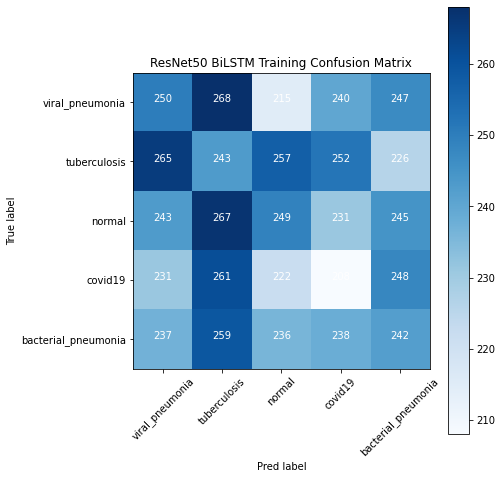

In [11]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("ResNet50 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [12]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = True

80150528/80134624 [==============================] - 2s 0us/step


### Our Model

In [13]:
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(TimeDistributed(Flatten()))
model_VGG19.add(Bidirectional(LSTM(64, return_sequences=True)))
model_VGG19.add(Bidirectional(LSTM(16, return_sequences=True)))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(64, activation='relu'))
model_VGG19.add(Dense(16, activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Flatten())
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 3584)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 7, 128)            1868288   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 7, 32)             18560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 32)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 7, 64)             2112      
_________________________________________________________________
dense_4 (Dense)              (None, 7, 16)            

In [14]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True              
callback = CustomCallback()
# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 106s 279ms/step - loss: 1.0333 - acc: 0.6426 - val_loss: 0.8870 - val_acc: 0.7475
Epoch 3/30
380/380 [==============================] - 107s 282ms/step - loss: 0.8255 - acc: 0.7508 - val_loss: 0.7567 - val_acc: 0.7200
Epoch 4/30
380/380 [==============================] - 106s 280ms/step - loss: 0.6728 - acc: 0.8054 - val_loss: 0.6727 - val_acc: 0.7352
Epoch 5/30
380/380 [==============================] - 106s 279ms/step - loss: 0.5870 - acc: 0.8238 - val_loss: 0.6515 - val_acc: 0.7413
Epoch 6/30
380/380 [==============================] - 107s 280ms/step - loss: 0.5115 - acc: 0.8470 - val_loss: 0.6604 - val_acc: 0.7383
Epoch 7/30
380/380 [==============================] - 107s 280ms/step - loss: 0.4632 - acc: 0.8612 - val_loss: 0.5046 - val_acc: 0.8045
Epoch 8/30
380/380 [==============================] - 106s 279ms/step - loss: 0.4184 - acc: 0.8704 - val_loss: 0.6637 - val_acc: 0.7220
Epoch 9/30
380/380 [============================

In [ ]:
model_VGG19.save("VGG19_model_skenario1.h5")
with open('history_VGG19.txt', mode='w') as file:
    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
    file.close()

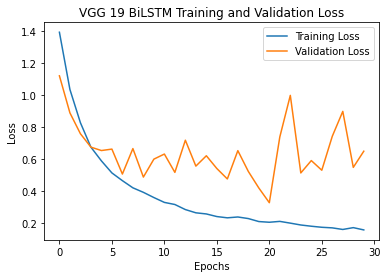

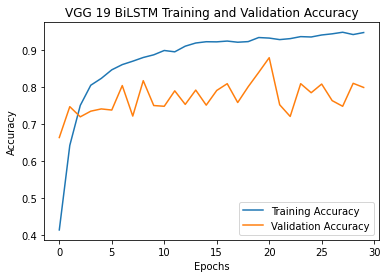

In [16]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('VGG 19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG 19 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 8s 61ms/step - loss: 0.6473 - acc: 0.7994
Loss: 0.6472896337509155
Accuracy: 0.7993890047073364


In [18]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nVGG 19 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 83s 215ms/step

VGG 19 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.17876   0.16967   0.17410      1220
            covid19    0.20455   0.19549   0.19992      1243
             normal    0.19726   0.20972   0.20330      1235
       tuberculosis    0.18761   0.18376   0.18566      1170
    viral_pneumonia    0.19686   0.20710   0.20185      1212

           accuracy                        0.19326      6080
          macro avg    0.19301   0.19315   0.19296      6080
       weighted avg    0.19310   0.19326   0.19307      6080



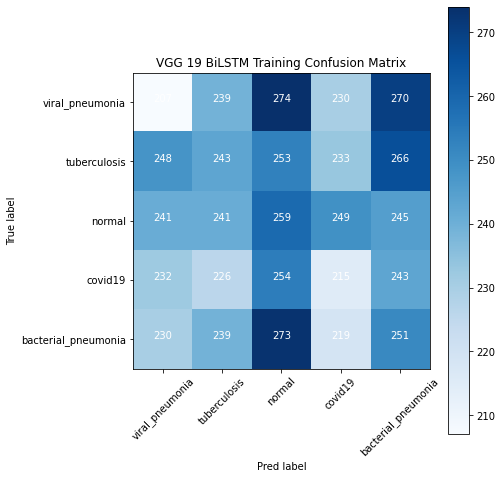

In [19]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("VGG 19 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [20]:
InceptionV3_model = InceptionV3(weights='imagenet', 
                                include_top=False, input_shape=(224, 224, 3))
# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = True

87924736/87910968 [==============================] - 3s 0us/step


In [21]:
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(TimeDistributed(Flatten()))
model_InceptionV3.add(Bidirectional(LSTM(64, return_sequences=True)))
model_InceptionV3.add(Bidirectional(LSTM(16, return_sequences=True)))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(64, activation='relu'))
model_InceptionV3.add(Dense(16, activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))
print(model_InceptionV3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 10240)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 5, 128)            5276160   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 5, 32)             18560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 5, 64)             2112      
_________________________________________________________________
dense_7 (Dense)              (None, 5, 16)            

In [22]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True              
callback = CustomCallback()
# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator#,
   # callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 106s 242ms/step - loss: 1.4258 - acc: 0.4097 - val_loss: 1.1826 - val_acc: 0.5489
Epoch 2/30
380/380 [==============================] - 88s 230ms/step - loss: 1.0903 - acc: 0.5850 - val_loss: 0.9338 - val_acc: 0.6436
Epoch 3/30
380/380 [==============================] - 88s 232ms/step - loss: 0.9131 - acc: 0.6757 - val_loss: 0.8175 - val_acc: 0.6782
Epoch 4/30
380/380 [==============================] - 88s 232ms/step - loss: 0.7919 - acc: 0.7339 - val_loss: 0.6608 - val_acc: 0.7821
Epoch 5/30
380/380 [==============================] - 88s 231ms/step - loss: 0.6755 - acc: 0.7934 - val_loss: 0.6284 - val_acc: 0.7607
Epoch 6/30
380/380 [==============================] - 89s 235ms/step - loss: 0.5902 - acc: 0.8181 - val_loss: 0.5405 - val_acc: 0.7984
Epoch 7/30
380/380 [==============================] - 89s 234ms/step - loss: 0.5199 - acc: 0.8459 - val_loss: 0.6391 - val_acc: 0.7495
Epoch 8/30
380/380 [==============================] - 

In [ ]:
model_InceptionV3.save("InceptionV3_model.h5")
with open('history_InceptionV3.txt', mode='w') as file:
    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
    file.close()

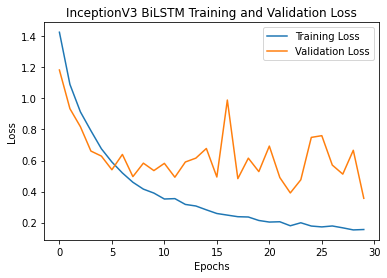

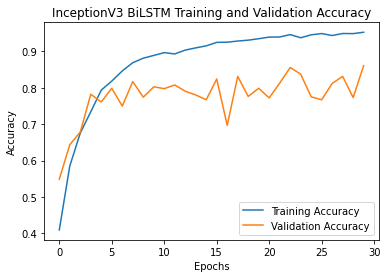

In [23]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 5s 42ms/step - loss: 0.3566 - acc: 0.8605
Loss: 0.3566269278526306
Accuracy: 0.860488772392273


In [26]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nInceptionV3 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 81s 212ms/step

InceptionV3 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19532   0.19836   0.19683      1220
            covid19    0.21606   0.20998   0.21297      1243
             normal    0.19279   0.19919   0.19594      1235
       tuberculosis    0.20626   0.20855   0.20739      1170
    viral_pneumonia    0.18058   0.17492   0.17770      1212

           accuracy                        0.19819      6080
          macro avg    0.19820   0.19820   0.19817      6080
       weighted avg    0.19821   0.19819   0.19817      6080



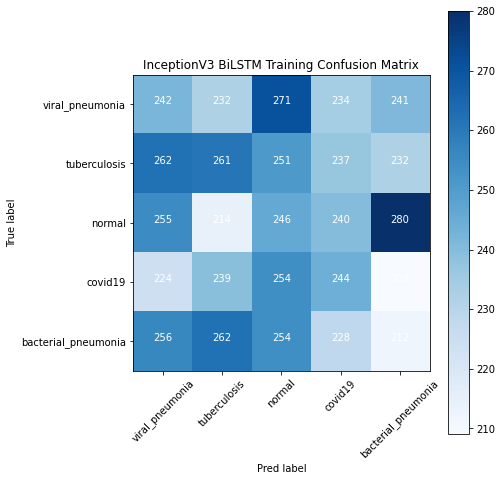

In [27]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("InceptionV3 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()